In [ ]:
from google.colab import files
files.upload()

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
kaggle.json


In [ ]:
!kaggle datasets download -d robikscube/hourly-energy-consumption
#https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

 44% 5.00M/11.4M [00:00<00:00, 42.1MB/s]
100% 11.4M/11.4M [00:00<00:00, 77.9MB/s]


In [ ]:
!apt install unzip
!unzip /content/hourly-energy-consumption.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Archive:  /content/hourly-energy-consumption.zip
  inflating: AEP_hourly.csv          
  inflating: COMED_hourly.csv        
  inflating: DAYTON_hourly.csv       
  inflating: DEOK_hourly.csv         
  inflating: DOM_hourly.csv          
  inflating: DUQ_hourly.csv          
  inflating: EKPC_hourly.csv         
  inflating: FE_hourly.csv           
  inflating: NI_hourly.csv           
  inflating: PJME_hourly.csv         
  inflating: PJMW_hourly.csv         
  inflating: PJM_Load_hourly.csv     
  inflating: est_hourly.paruqet      
  inflating: pjm_hourly_est.csv      


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_csv("/content/PJME_hourly.csv")
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [ ]:
df = df.set_index('Datetime')

In [ ]:
color_pal = sns.color_palette()
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

<AxesSubplot:title={'center':'PJME Energy used in MW'}, xlabel='Datetime'>

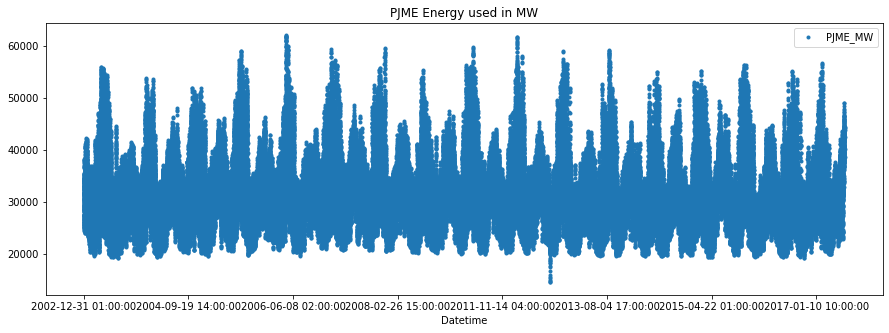

In [ ]:
df.plot(style = '.', figsize=(15,5), color= color_pal[0], title='PJME Energy used in MW')

In [ ]:
df.index = pd.to_datetime(df.index) #casting from type object to type datetime

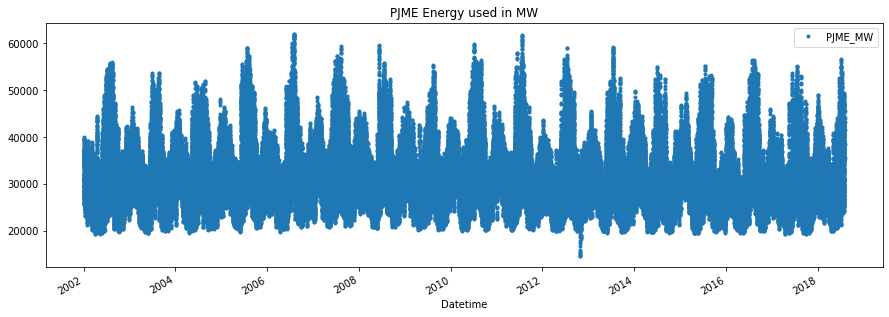

In [ ]:
df.plot(style = '.', 
        figsize=(15,5), 
        color= color_pal[0], 
        title='PJME Energy used in MW')
plt.show()

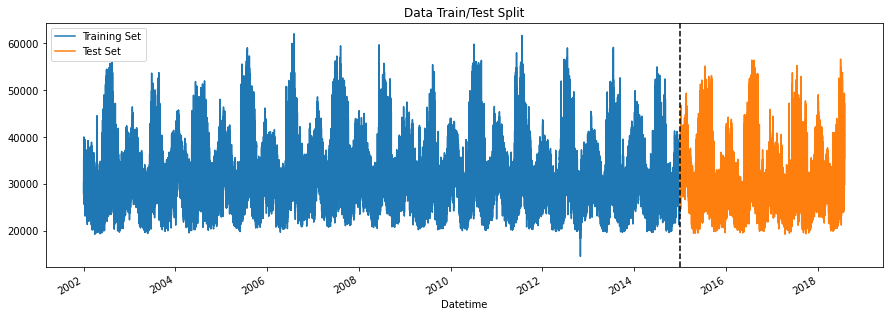

In [ ]:
# TRAIN TEST SPLIT
train = df.loc[df.index < '01-01-2015'] #locating the rows for train where date is before Jan 1st, 2015
test = df.loc[df.index >= '01-01-2015'] #locating the remaining rows for test

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

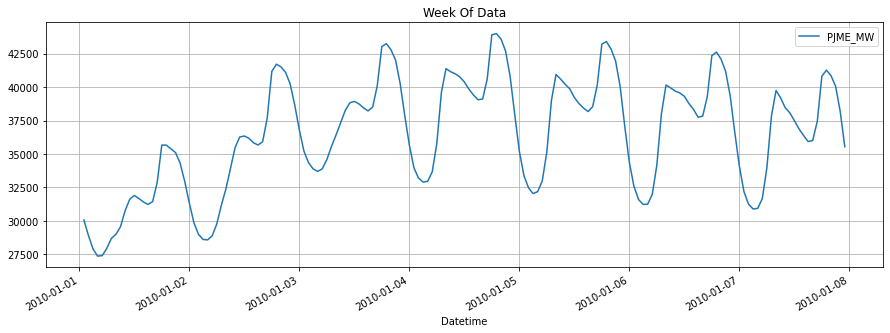

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.grid()
plt.show()

We can see above that within each day there are two different peaks, which is pretty common in energy consumption.

# **Feature Creation**

In [ ]:
df.index.hour #just the hour component

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='Datetime', length=145366)

In [ ]:
 def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
df = create_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,31,1


## **Visualize our Feature/Target Relationship**

Text(0.5, 1.0, 'MW by hour')

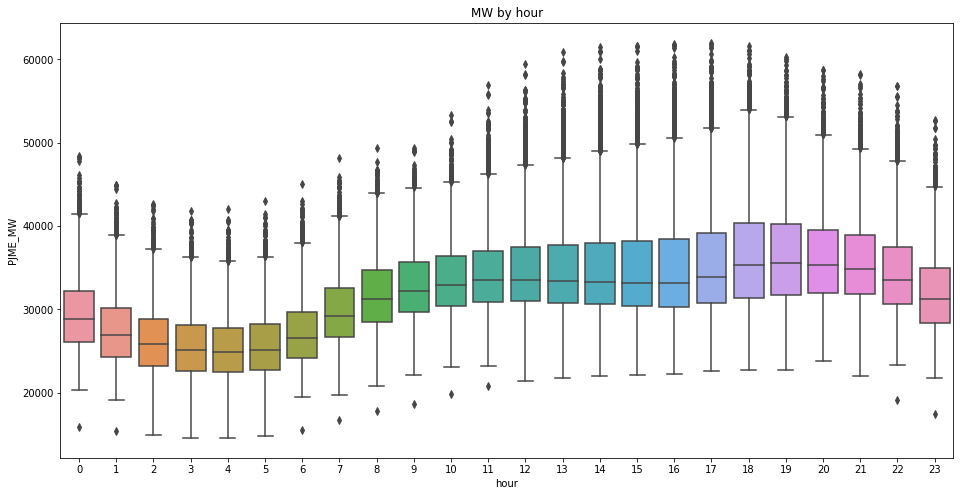

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by hour')

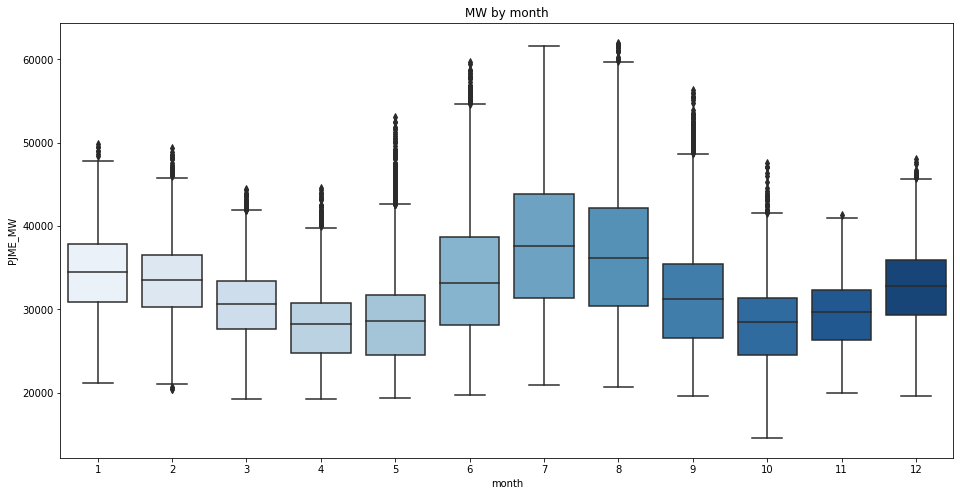

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by month')
plt.show()

peaks in winter and summer when people are using AC

In [ ]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'dayofmonth', 'weekofyear'],
      dtype='object')

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

# **Create Model**

In [ ]:
reg = xgb.XGBRegressor(base_score = 0.5,
                       booster = 'gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective = 'reg:linear',
                       max_depth = 3,
                       learning_rate= 0.01)
reg.fit(X_train, y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)],
        verbose=True)

[00:10:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[1]	validation_0-rmse:32286.40137	validation_1-rmse:31338.35868
[2]	validation_0-rmse:31970.92157	validation_1-rmse:31022.83007
[3]	validation_0-rmse:31658.67013	validation_1-rmse:30710.55260
[4]	validation_0-rmse:31349.60743	validation_1-rmse:30403.05355
[5]	validation_0-rmse:31043.70424	validation_1-rmse:30097.14832
[6]	validation_0-rmse:30740.92832	validation_1-rmse:29795.95182
[7]	validation_0-rmse:30441.24706	validation_1-rmse:29496.29411
[8]	validation_0-rmse:30144.63129	validation_1-rmse:29201.27507
[9]	validation_0-rmse:29851.05599	validation_1-rmse:28907.74763
[10]	validation_0-rmse:29560.48479	validation_1-rmse:28618.78998
[11]	validation_0-rmse:29272.88912	validation_1-rmse:28331.49888
[12]	validation_0-rmse:28988.24388	validation_1-rmse:28048.48819
[13]	validation_0-rmse:28706.51425	validation_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [ ]:
fi = pd.DataFrame(data = reg.feature_importances_,
             index = reg.feature_names_in_,
             columns = ['importance'])

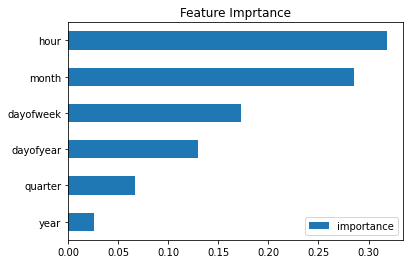

In [ ]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Imprtance')
plt.show()

Forecast on Test

In [ ]:
test['predictions'] = reg.predict(X_test)

In [ ]:
df = df.merge(test[['predictions']], how='left', left_index=True, right_index=True)

In [ ]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,predictions
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42689.429688
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,42547.425781
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,40844.238281


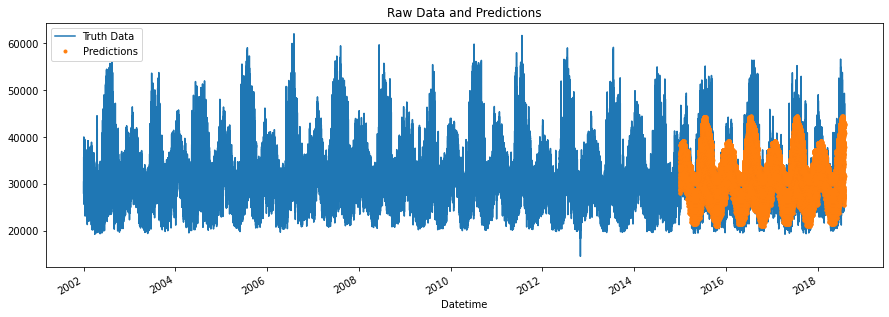

In [ ]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['predictions'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

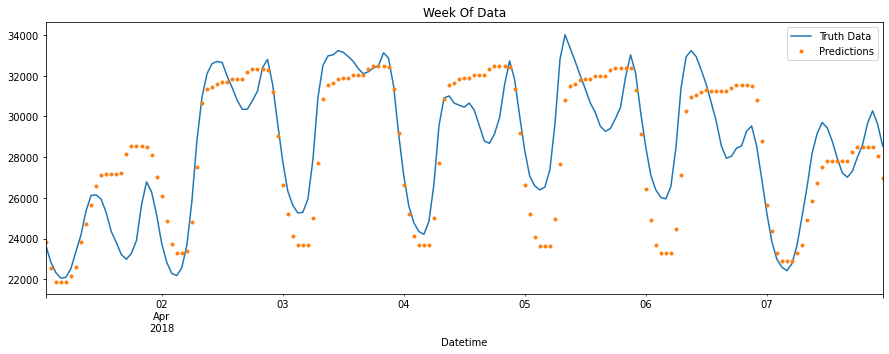

In [ ]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['predictions'] \
    .plot(style='.')
plt.legend(['Truth Data','Predictions'])
plt.show()

## **Score(RMSE)**

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['predictions']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3721.75


## **Error Calculation**

Sorted in worst to best predicted days

In [ ]:
test['error'] = np.abs(test[TARGET] - test['predictions'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12839.597087
2016-08-14    12780.209961
2016-09-10    11356.302979
2015-02-20    10965.982259
2016-09-09    10864.954834
2018-01-06    10506.845622
2016-08-12    10124.051595
2015-02-21     9881.803711
2015-02-16     9781.552246
2018-01-07     9739.144206
Name: error, dtype: float64

In [ ]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

date
2017-10-24    349.390462
2015-10-28    397.410807
2016-10-27    528.968913
2015-05-06    529.528971
2017-10-15    535.292318
2018-05-16    585.349935
2016-10-08    625.825439
2015-10-03    653.130941
2016-09-16    656.402995
2015-11-06    674.912109
Name: error, dtype: float64

Some of the worst predictions were made in August. On the other hand, some of the best predictions were made in October.